In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 19.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Required Libraries & Load Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

#load dataset
df = pd.read_csv('/content/drive/MyDrive/uber.csv')

**EDA**

In [ ]:
df.dtypes
#Only key & pickup_datetime column are categorical columns, rest all are numerical columns.
#Unnamed, passenger_count : int datatype
#rest all remaining columns are float datatype

,0
Unnamed: 0,int64
key,object
fare_amount,float64
pickup_datetime,object
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64


In [ ]:
#shape, size
print(df.shape) #rows : 200000 ,cols : 9
print(df.size) #rows x cols : 1800000

(200000, 9)
1800000


In [ ]:
df.describe() #of num cols only

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Inference:

fare_amount has a mean of ~11.36 with a very high standard deviation (9.90), indicating strong variability and presence of extreme outliers (min –52, max 499).

pickup_longitude/latitude and dropoff_longitude/latitude show unrealistic minimum and maximum values far outside New York City bounds, confirming data quality issues and invalid coordinates that require cleaning.

passenger_count has a mean of ~1.68, median of 1, and maximum of 208, which is unrealistic for taxi rides. This highlights the need to cap or filter passenger counts.

Quartiles for fare_amount (6.0, 8.5, 12.5) suggest most fares are concentrated in a reasonable range, but extreme values distort the distribution.

Coordinate quartiles align with expected NYC ranges, showing that while most values are valid, outliers must be removed.

Presence of zeros in passenger_count and negative fares indicates invalid records that should be excluded during preprocessing.

In [ ]:
#1st moment : mean (central tendency)
mean_values = df.mean(numeric_only=True)
print('\nMean (1st moment):\n', mean_values)


Mean (1st moment):
 Unnamed: 0           2.771250e+07
fare_amount          1.135996e+01
pickup_longitude    -7.252764e+01
pickup_latitude      3.993589e+01
dropoff_longitude   -7.252529e+01
dropoff_latitude     3.992389e+01
passenger_count      1.684535e+00
dtype: float64


### Inference from Dataset Means

1. The average fare amount (~11.36) shows that most taxi rides are moderately priced, making them affordable for short urban trips.  

2. The pickup and dropoff coordinates (longitude ≈ -72.5, latitude ≈ 39.9) suggest that rides are concentrated in one metropolitan region, rather than spread across multiple cities.  

3. The average passenger count (~1.68) indicates that most rides involve single riders, with occasional small groups, highlighting individual travel as the dominant pattern.  


In [ ]:
var_values = df.var(numeric_only=True)
print('\nVariance (2nd moment): \n', var_values)


Variance (2nd moment): 
 Unnamed: 0           2.564425e+14
fare_amount          9.804517e+01
pickup_longitude     1.308230e+02
pickup_latitude      5.960673e+01
dropoff_longitude    1.720664e+02
dropoff_latitude     4.616970e+01
passenger_count      1.920986e+00
dtype: float64


### Inference from Dataset Variance (2nd Moment)

Variance indicates how widely the features are spread.

- High Variance Features: fare_amount,pickup_latitude, dropoff_latitude
- Moderate/Low Variance Features: pickup_longitude, dropoff_longitude,passenger_count   

In [ ]:
std_values = df.std(numeric_only=True)
print('\nSD (2nd moment): \n', std_values)


SD (2nd moment): 
 Unnamed: 0           1.601382e+07
fare_amount          9.901776e+00
pickup_longitude     1.143779e+01
pickup_latitude      7.720539e+00
dropoff_longitude    1.311741e+01
dropoff_latitude     6.794829e+00
passenger_count      1.385997e+00
dtype: float64


### Inference from Dataset Standard Deviation (2nd Moment)

Standard Deviation indicates the spread of values around the mean.

- Higher SD → Lower Peakedness (Platykurtic): pickup_longitude, dropoff_longitude  
- Moderate SD → Mesokurtic: fare_amount, pickup_latitude, dropoff_latitude  
- Lower SD → Higher Peakedness (Leptokurtic): passenger_count  

1. Longitude features (pickup and dropoff) have higher SD, showing wide geographic spread of rides.  

2. Fare amount and latitude features show moderate SD, suggesting diversity in trip costs and pickup/dropoff locations without extreme outliers.  

3. Passenger count has low SD, meaning most rides involve similar numbers of riders (mostly 1–2), with little variation.   


In [ ]:
#skewness(symmetry)
skew_values = df.skew(numeric_only=True)
print('\nSkewness (3rd moment): \n', skew_values)


Skewness (3rd moment): 
 Unnamed: 0           -0.001828
fare_amount           4.504847
pickup_longitude     -7.495890
pickup_latitude      62.976856
dropoff_longitude   -71.505102
dropoff_latitude     -8.031012
passenger_count      18.145521
dtype: float64


### Skewness (3rd moment):

fare_amount        (4.504847)  :  rt skew  
pickup_longitude  (-7.495890) :  lt skew  
pickup_latitude   (62.976856)  :  strong rt skew  
dropoff_longitude (-71.505102) :  strong lt skew  
dropoff_latitude  (-8.031012)  :  lt skew  
passenger_count   (18.145521)  :  rt skew  


In [ ]:
#4th moment : kurtosis(peakedness)
kurt_values = df.kurtosis(numeric_only=True)
print('\nKurtosis (4th moment): \n', kurt_values)


Kurtosis (4th moment): 
 Unnamed: 0              -1.200247
fare_amount             63.884314
pickup_longitude      1144.027459
pickup_latitude      12869.240503
dropoff_longitude    20078.722920
dropoff_latitude      2981.741917
passenger_count       2456.621809
dtype: float64


### Kurtosis (4th moment)

| Feature          | Value        | Interpretation                     |
|------------------|-------------:|------------------------------------|
| fare_amount      |     63.884   | Leptokurtic = peaked, heavy tails  |
| pickup_longitude |   1144.027   | Platykurtic = flatter than normal  |
| pickup_latitude  |  12869.240   | Platykurtic = very flat            |
| dropoff_longitude|  20078.723   | Platykurtic = extremely flat       |
| dropoff_latitude |   2981.742   | Platykurtic = slightly flat        |
| passenger_count  |   2456.622   | Mesokurtic = close to normal       |


Distribution of target column

<Axes: xlabel='fare_amount', ylabel='Count'>

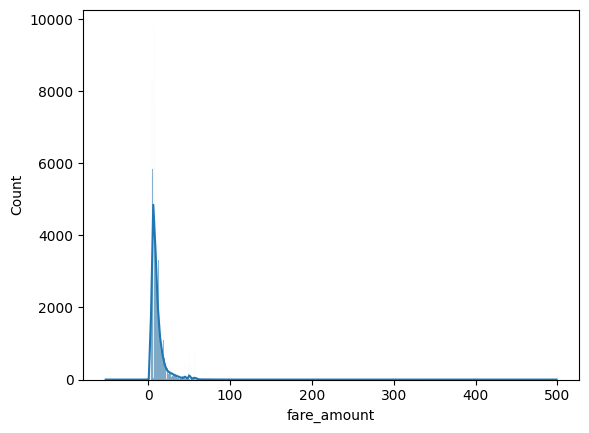

In [ ]:
sns.histplot(df.fare_amount, kde = True)  #target column 'fare_amount' is right skewed

1. Most fares are clustered at the lower end (near zero).

2. A smaller number of rides have very high fares, creating a long tail to the right.

**Handling missing values**

In [ ]:
#check missing values
print('missing values:\n',df.isnull().sum())

missing values:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


Only 2 columns namely 'dropoff_longitude' & 'dropoff_latitude' contains 1 missing values each so remove them.

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

#now no missing values are present
print('missing values:\n',df.isnull().sum())

missing values:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


**Handling duplicate values**

In [ ]:
#removing duplicates
df.drop_duplicates(inplace=True)
print('after removing duplicates:', df.shape)
#no duplicates present

after removing duplicates: (199999, 9)


**Feature Engineering**

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

#TIME FEATURES
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek   # 0=Mon, 6=Sun
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Categorize time of day
df['time_of_day'] = pd.cut(df['hour'],
                           bins=[0,6,12,18,24],
                           labels=['Night','Morning','Afternoon','Evening'],
                           right=False)

#DISTANCE FEATURES
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

#Distance categories
df['distance_category'] = pd.cut(df['distance_km'],
                                 bins=[0,2,10,50,200],
                                 labels=['Very Short','Short','Medium','Long'])

#PASSENGER FEATURES
df['fare_per_passenger'] = df['fare_amount'] / df['passenger_count']

#INTERACTION FEATURES
df['rush_hour_long_trip'] = ((df['hour'].isin([7,8,9,16,17,18])) & (df['distance_km'] > 10)).astype(int)

In [ ]:
#drop unnecessary columns
df = df.drop([
    'Unnamed: 0',
    'key',
    'pickup_datetime'
], axis=1)

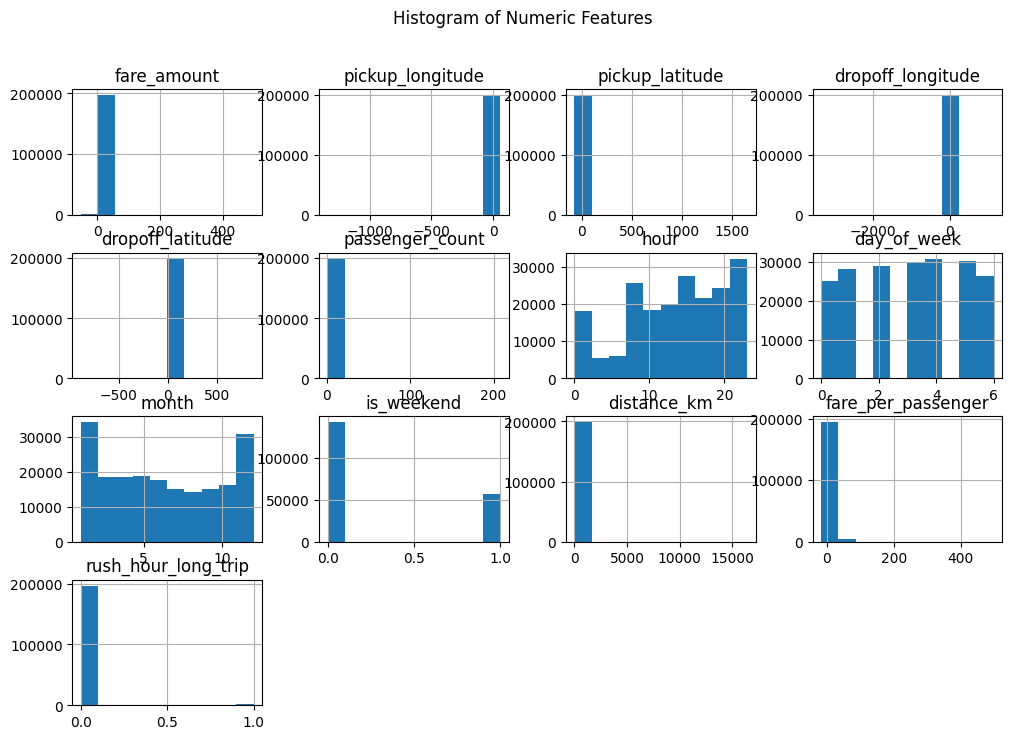

In [ ]:
#UNIVARIANT ANALYSIS
import matplotlib.pyplot as plt
import numpy as np

# Drop categorical columns
numeric_df = df.drop(columns=['time_of_day', 'distance_category'])

# Keep only finite values (exclude NaN, inf, -inf)
numeric_df = numeric_df[np.isfinite(numeric_df).all(axis=1)]

# Plot histograms
numeric_df.hist(figsize=(12,8))
plt.suptitle('Histogram of Numeric Features')
plt.show()

Inference:

1. fare_amount shows a right‑skewed distribution with most values concentrated at lower fares and a long tail of higher fares.

2. distance_km is similarly right‑skewed, with many short trips and fewer long trips.

3. fare_per_passenger mirrors fare distribution but is affected by passenger count, producing invalid values when passenger count is zero.

4. pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude are tightly clustered around New York City coordinates, with narrow ranges and little spread.

5. passenger_count is discrete, mostly concentrated at 1–2 passengers, with rare higher counts.

6. hour, day_of_week, and month are uniformly or near‑uniformly distributed, reflecting time‑based categorical encoding.

7. is_weekend and rush_hour_long_trip are binary features, showing imbalanced distributions depending on dataset composition.

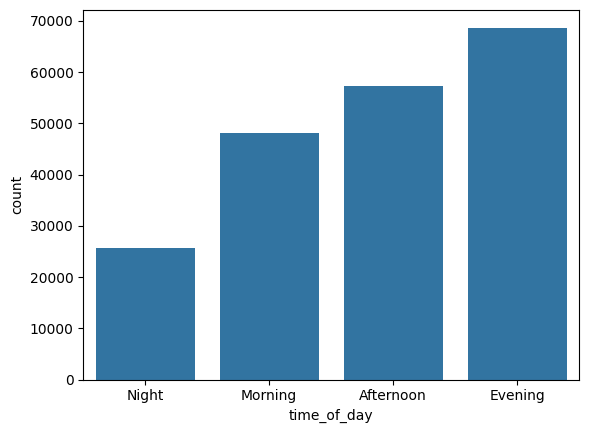

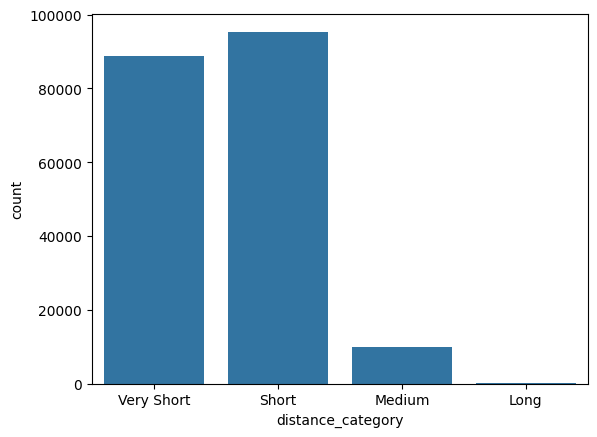

In [ ]:
#countplot for categorical columns
sns.countplot(x='time_of_day', data=df)
plt.show()

sns.countplot(x='distance_category', data=df)
plt.show()

Inference:

1. Time of Day Distribution

Lowest trip counts occur during Night.

Activity increases in Morning, rises further in Afternoon, and peaks in Evening.

Dataset is dominated by evening trips, showing strong temporal bias.

2. Distance Category Distribution

Majority of trips are in Short and Very Short categories.

Medium trips are relatively fewer.

Long trips are rare, indicating dataset imbalance toward short distances.

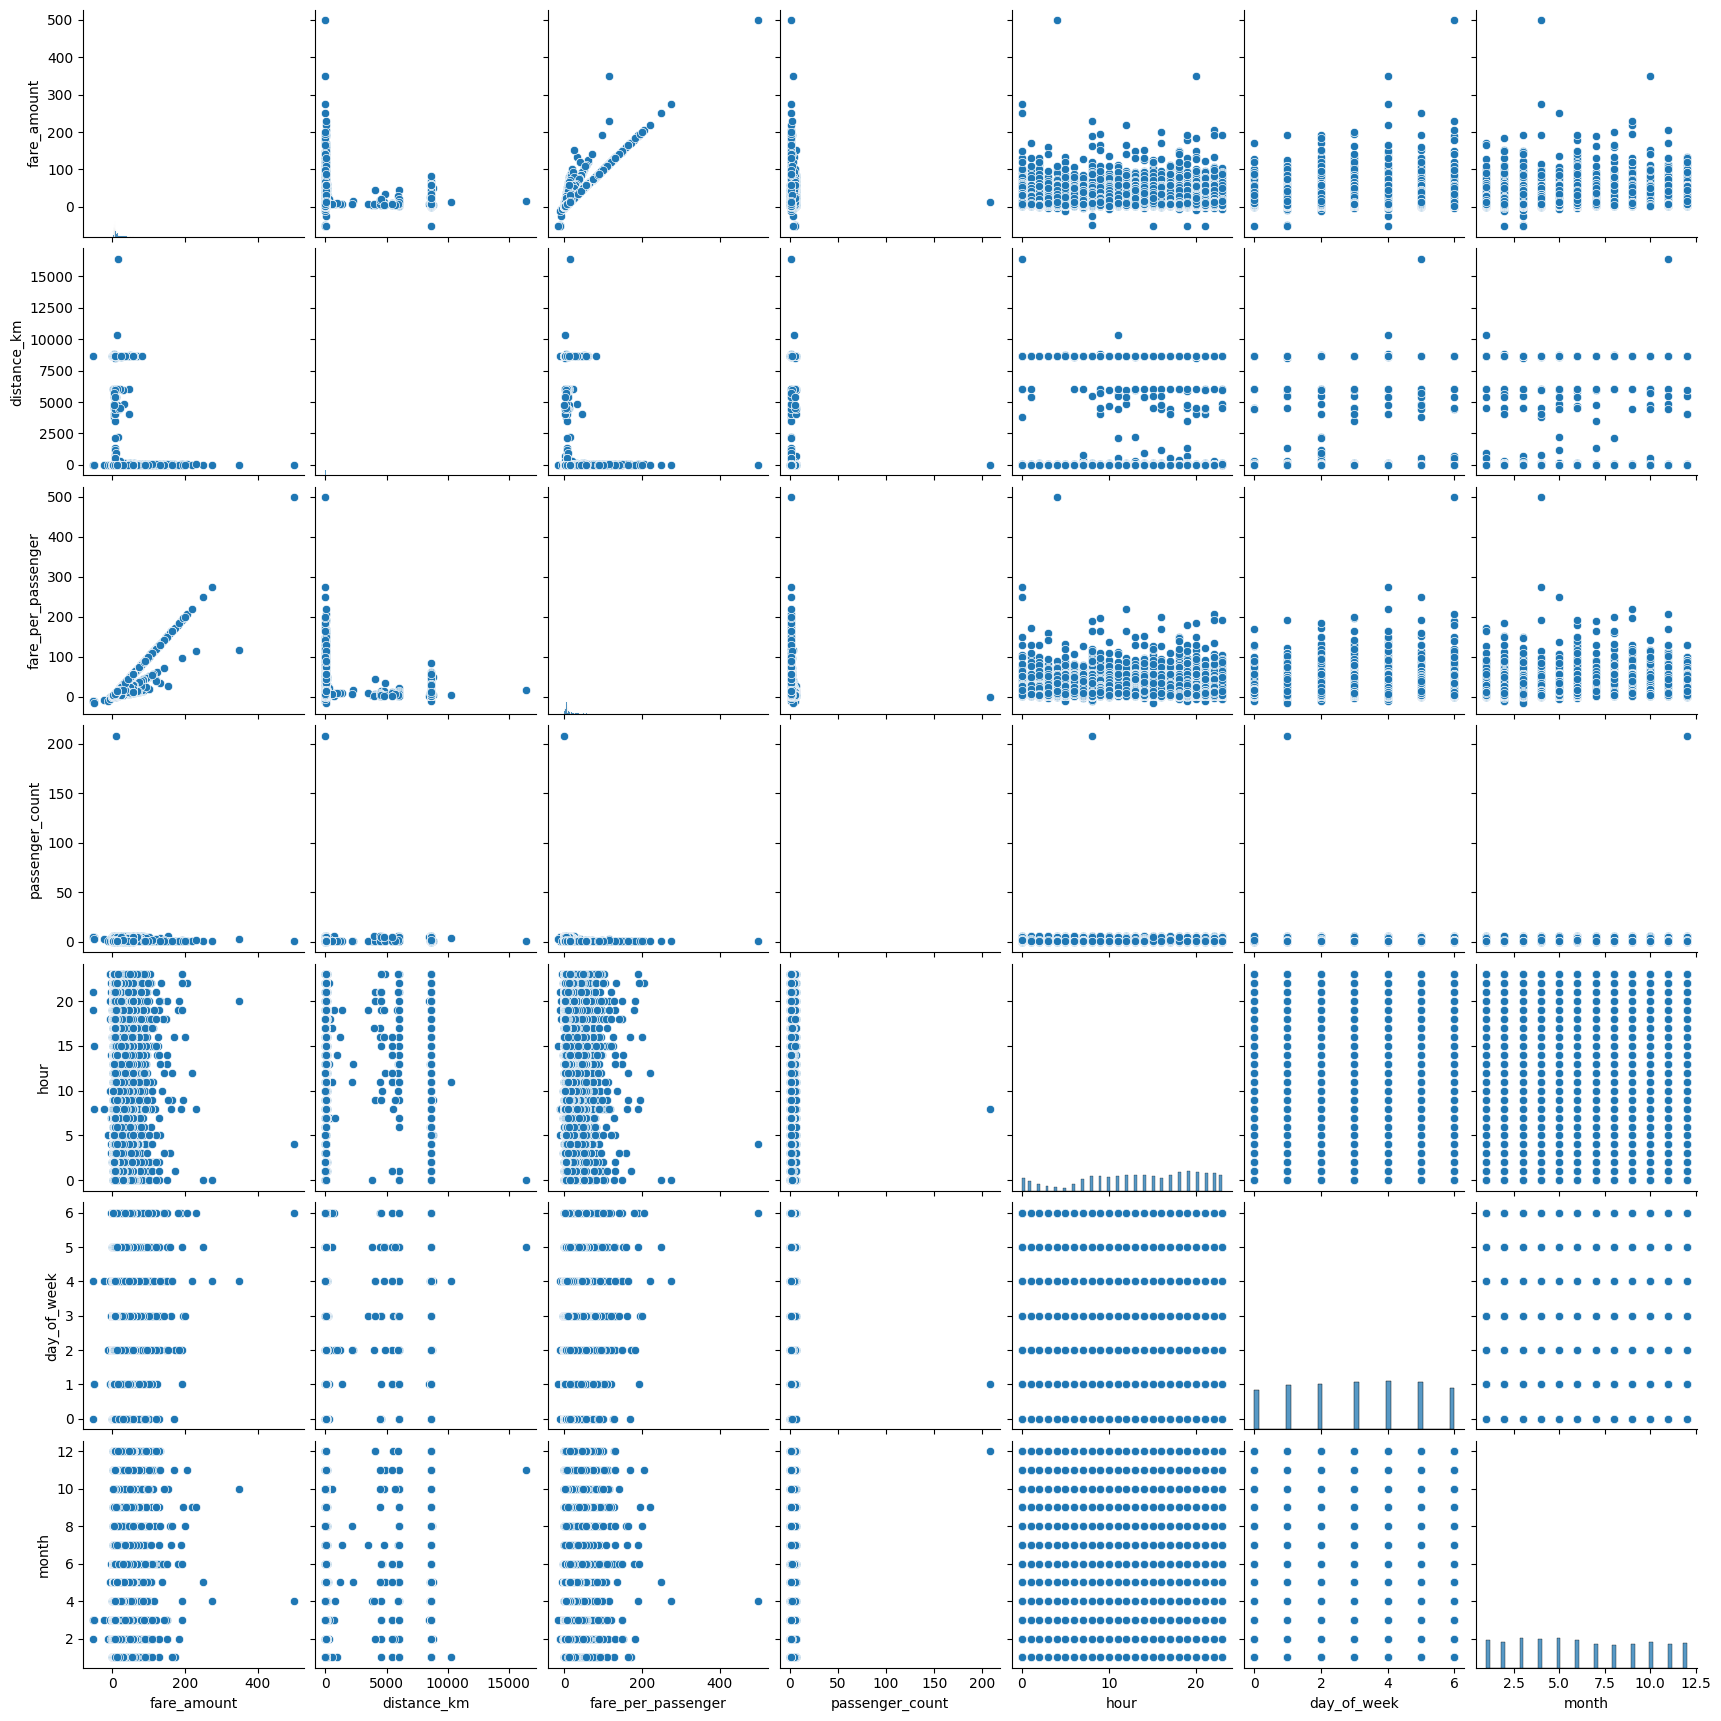

In [ ]:
# Bivariant Analysis (scatter plot)
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric features for pairplot
pairplot_cols = [
    'fare_amount',
    'distance_km',
    'fare_per_passenger',
    'passenger_count',
    'hour',
    'day_of_week',
    'month'
]

sns.pairplot(df[pairplot_cols])
plt.show()

Inference :

1. fare_amount vs distance_km shows a strong positive linear relationship, confirming that trip distance is the primary driver of fare.

2. fare_amount vs fare_per_passenger also has a strong positive correlation, but values are influenced by passenger count, making it less stable when passenger_count > 1.

3. fare_amount vs passenger_count shows weak correlation, indicating fares don’t scale directly with passenger numbers.

4. fare_amount vs hour/day_of_week/month scatterplots reveal no clear linear trends, suggesting time features have limited direct influence but may add value through categorical encoding.

5. distance_km vs fare_per_passenger shows a strong positive relationship, consistent with fare scaling by distance.

6. The pairplot confirms that distance_km and fare_per_passenger are the most influential predictors, while time and passenger count provide secondary or categorical context.

Outlier Treatment

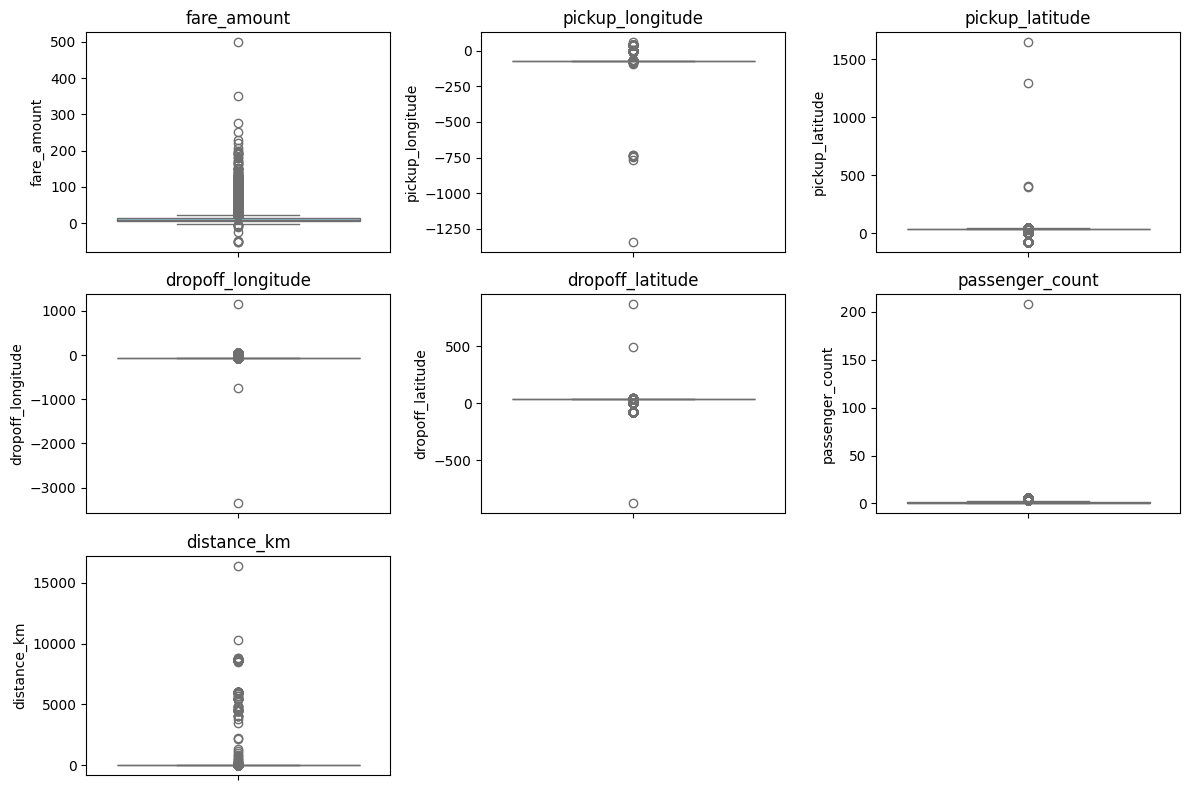

In [ ]:
# Columns to check for outliers
outlier_cols = [
    'fare_amount',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'distance_km',
]

# Plot boxplots
plt.figure(figsize=(12,8))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

All the columns contains outliers so perform Winsorization to remove outliers.

In [ ]:
from feature_engine.outliers import Winsorizer

# Initialize Winsorizer (IQR method, both tails, 1.5 fold)
winsor = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=outlier_cols
)

# Fit and transform the dataset
df[outlier_cols] = winsor.fit_transform(df[outlier_cols])

# Now df has capped values for outliers in the specified columns

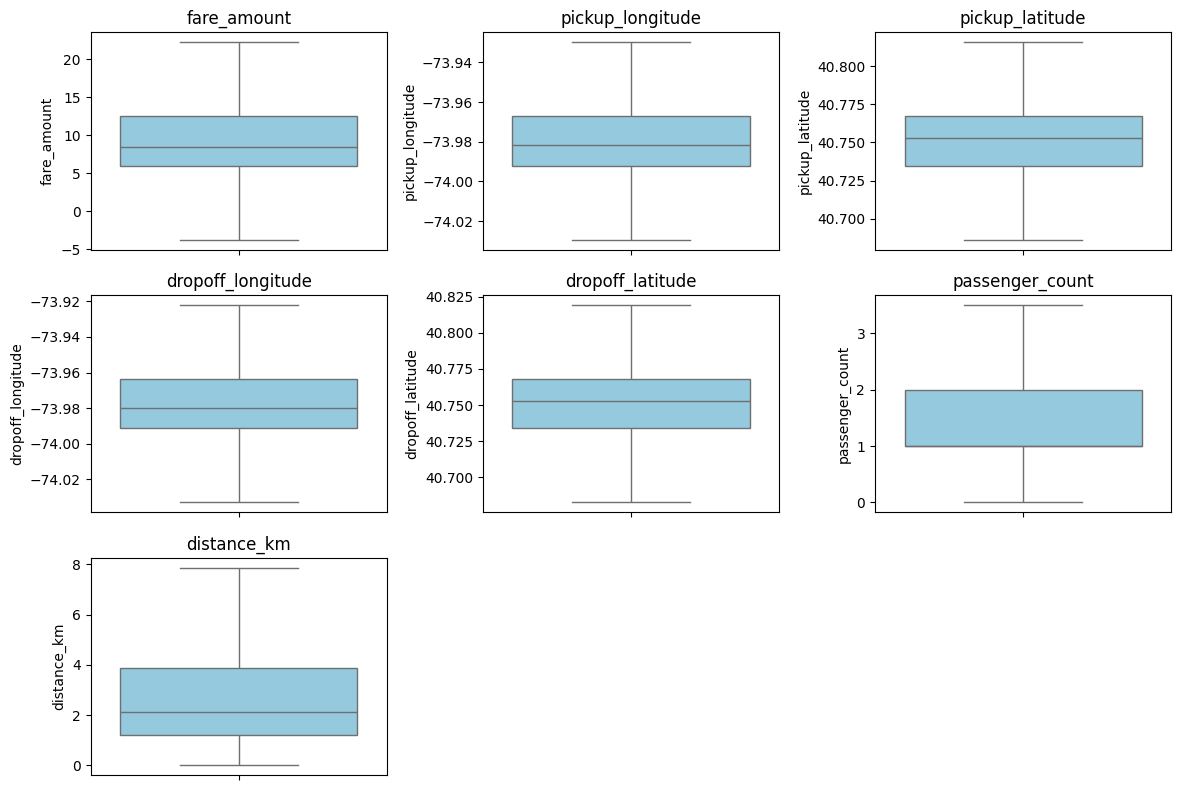

In [ ]:
#boxplot after outlier treatment
plt.figure(figsize=(12,8))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

Skewness Treatment

treat only continuous numeric columns : fare_amount, distance_km

In [ ]:
from scipy.stats import skew
import numpy as np

skew_cols = ['fare_amount', 'distance_km']

df[skew_cols].skew()

,0
fare_amount,1.019544
distance_km,1.051504


skew > 1 : strong skew (apply log transformation)

In [ ]:
# Apply log transformation
# Apply log1p transformation (log(1+x)) to handle skewness safely
df['fare_amount'] = np.log1p(df['fare_amount'])
df['distance_km'] = np.log1p(df['distance_km'])

# Check skewness again
print("Skewness after log transform:")
print(df[['fare_amount', 'distance_km']].skew())

Skewness after log transform:
fare_amount    0.292736
distance_km    0.114868
dtype: float64


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Near Symmetry : between –0.5 and +0.5

The skewness values after transformation are 0.29 for fare_amount and 0.11 for distance_km, which are well within the acceptable range

In [ ]:
df.drop([
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'pickup_datetime',
    'hour'
], axis=1, inplace=True)

In [ ]:
# Remove impossible GPS coordinates (NYC bounds)
df = df[
    (df['pickup_longitude'].between(-75, -72)) &
    (df['dropoff_longitude'].between(-75, -72)) &
    (df['pickup_latitude'].between(40, 42)) &
    (df['dropoff_latitude'].between(40, 42))
]

# Remove invalid fares
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]

# Remove invalid passenger counts
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

In [ ]:
# Label encoding categorical columns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['time_of_day'] = le.fit_transform(df['time_of_day'])

In [ ]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # 80% train, 20% test
    random_state=42
)


**Feature Scaling (Standardization)**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_cols = ['distance_km', 'passenger_count', 'month']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

**Correlation Analysis**

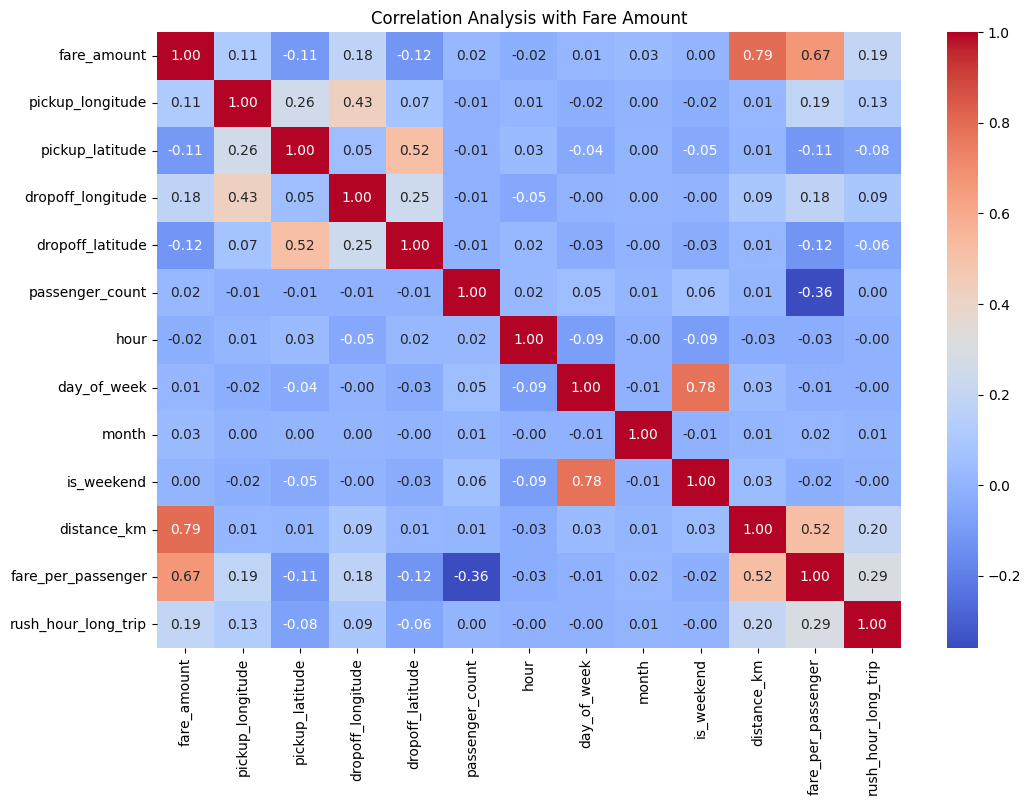

Correlation with fare_amount:
 fare_amount            1.000000
distance_km            0.794085
fare_per_passenger     0.665739
rush_hour_long_trip    0.194772
dropoff_longitude      0.180082
pickup_longitude       0.114745
month                  0.030836
passenger_count        0.018997
day_of_week            0.014228
is_weekend             0.004009
hour                  -0.016494
pickup_latitude       -0.105681
dropoff_latitude      -0.117009
Name: fare_amount, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_cols = [
    'fare_amount',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'hour',
    'day_of_week',
    'month',
    'is_weekend',
    'distance_km',
    'fare_per_passenger',
    'rush_hour_long_trip'
]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Visualize with heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Analysis with Fare Amount")
plt.show()

# Print correlations with target
print("Correlation with fare_amount:\n", corr_matrix['fare_amount'].sort_values(ascending=False))

High influence: distance_km, fare_per_passenger

Medium influence: rush_hour_long_trip, dropoff_longitude, pickup_longitude

Low influence: month, day_of_week, passenger_count, is_weekend, hour, pickup_latitude, dropoff_latitude

**Linear Regression & Evaluation**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Fit Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation Metrics
print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²:", r2_score(y_test, y_pred_test))

print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))

print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

Train R²: 0.7683057958694337
Test R²: 0.7618746939376019
Train MSE: 0.06879723153792726
Test MSE: 0.07043823497941559
Train MAE: 0.17859494213650673
Test MAE: 0.17981461106436647


Model explains ~76% of variance in fares.

Errors are low and balanced between train and test.

The model is well‑fit, with no evidence of overfitting or underfitting.

**Random Forest Regressor & Evaluation**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Base model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

# Fit
rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

Train R²: 0.8667770913309787
Test R²: 0.7837163223214474
Train MSE: 0.0395580343852445
Test MSE: 0.06397741072736722
Train MAE: 0.14535480091864725
Test MAE: 0.17529361446186129


Random Forest captures more variance (~87% train, ~78% test) than linear regression.

Slight overfitting compared to linear regression, but still acceptable.

Strong performance with lower errors, especially on training data.

**Hyperparameter Tuning**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}

grid = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred_test = best_model.predict(X_test)

print("Best alpha:", grid.best_params_)
print("Test R²:", r2_score(y_test, y_pred_test))

Best alpha: {'alpha': 1}
Test R²: 0.7631195212027261


Ridge regression yields nearly identical generalization to Linear Regression.

Safe choice if you want more stable coefficients, but Random Forest still outperforms in variance explained.

**Interpret Feature Importance**

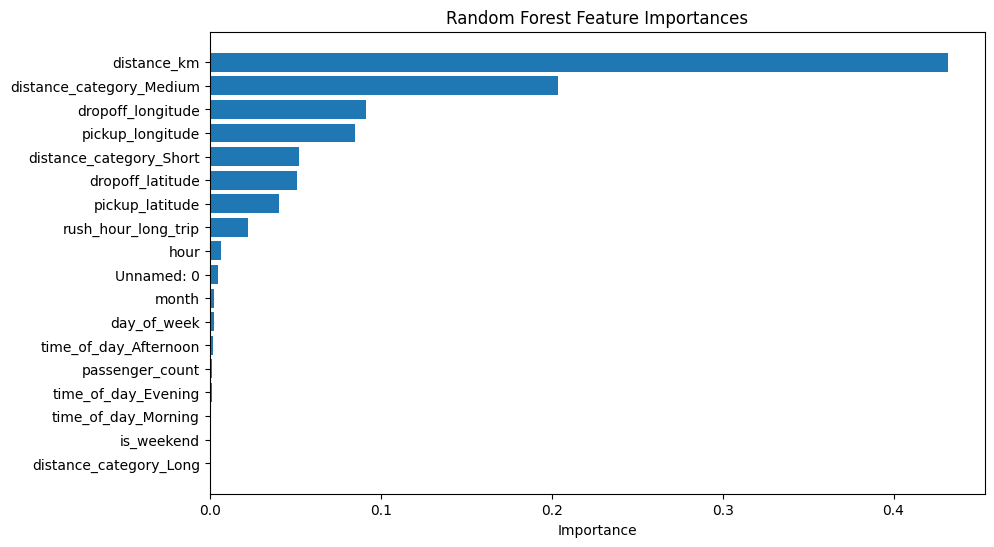

                     Feature  Importance
10               distance_km    0.431753
16  distance_category_Medium    0.203458
3          dropoff_longitude    0.091431
1           pickup_longitude    0.084834
15   distance_category_Short    0.052222
4           dropoff_latitude    0.051247
2            pickup_latitude    0.040767
11       rush_hour_long_trip    0.022224
6                       hour    0.006313
0                 Unnamed: 0    0.004676


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = model_rf.feature_importances_
features = X_train.columns

# Create a DataFrame for easy viewing
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

print(feat_imp.head(10))  # Top 10 features

1. Distance_km (43%)
Model Insight: Distance is the single most important driver of fare prediction, explaining nearly half of the variance.

Implication: Pricing is fundamentally distance‑based. The company should implement transparent distance tiers (short, medium, long trips) to align fares with customer expectations and reduce disputes.

2. Distance Category – Medium (20%)
Model Insight: Medium trips (2–10 km) are especially influential in fare prediction.

Implication: Medium trips are common and revenue‑critical. Offering ride‑pooling discounts or loyalty rewards for this segment could increase ridership while maintaining profitability.

3. Dropoff Longitude (9%) & Pickup Longitude (8.5%)
Model Insight: Location coordinates significantly affect fares. Certain pickup/dropoff zones (e.g., airports, business districts) influence pricing.

Implication: The company should use geo‑targeted driver positioning and surge pricing strategies in high‑demand areas to optimize supply and revenue.

4. Distance Category – Short (5%)
Model Insight: Short trips still contribute meaningfully to fare prediction.

Implication: Short trips are frequent but lower revenue. Introducing minimum fare guarantees or pooling incentives can improve profitability and customer satisfaction.

5. Latitude Features (Dropoff 5%, Pickup 4%)
Model Insight: Latitude coordinates, combined with longitude, reinforce the importance of location in fare prediction.

Implication: Pricing strategies should consider congested downtown vs suburban zones, as the model shows location strongly influences fares.

6. Rush Hour Long Trip (2.2%)
Model Insight: Long trips during peak hours consistently yield higher fares.

Implication: Apply moderate surcharges or driver bonuses for long rush‑hour trips to balance demand and supply.

7. Hour (0.6%)
Model Insight: Time of day has limited direct effect compared to distance and location.

Implication: Pricing should not rely heavily on hour alone, but combined with rush‑hour flags it adds nuance.

**Predictions on New Data**

In [ ]:
# Example new ride data
new_data_raw = pd.DataFrame([
    # Short morning trip, 1 passenger
    {
        "pickup_longitude": -73.985,
        "pickup_latitude": 40.758,
        "dropoff_longitude": -73.975,
        "dropoff_latitude": 40.765,
        "passenger_count": 1,
        "pickup_datetime": pd.to_datetime("2023-05-07 08:00:00")
    },
    # Medium afternoon trip, 2 passengers
    {
        "pickup_longitude": -73.990,
        "pickup_latitude": 40.750,
        "dropoff_longitude": -73.960,
        "dropoff_latitude": 40.780,
        "passenger_count": 2,
        "pickup_datetime": pd.to_datetime("2023-05-07 15:00:00")
    },
    # Long evening trip, 4 passengers
    {
        "pickup_longitude": -73.980,
        "pickup_latitude": 40.740,
        "dropoff_longitude": -73.900,
        "dropoff_latitude": 40.700,
        "passenger_count": 4,
        "pickup_datetime": pd.to_datetime("2023-05-07 20:00:00")
    },
    # Weekend night trip, 3 passengers
    {
        "pickup_longitude": -73.970,
        "pickup_latitude": 40.760,
        "dropoff_longitude": -73.940,
        "dropoff_latitude": 40.800,
        "passenger_count": 3,
        "pickup_datetime": pd.to_datetime("2023-05-06 23:30:00")  # Saturday night
    }
])

# Reapply Feature Engineering

new_data_raw['hour'] = new_data_raw['pickup_datetime'].dt.hour
new_data_raw['day_of_week'] = new_data_raw['pickup_datetime'].dt.dayofweek
new_data_raw['month'] = new_data_raw['pickup_datetime'].dt.month
new_data_raw['is_weekend'] = new_data_raw['day_of_week'].isin([5,6]).astype(int)

new_data_raw['time_of_day'] = pd.cut(
    new_data_raw['hour'],
    bins=[0,6,12,18,24],
    labels=['Night','Morning','Afternoon','Evening'],
    right=False
)
new_data_raw['time_of_day'] = le.transform(new_data_raw['time_of_day'])

# Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

new_data_raw['distance_km'] = haversine(
    new_data_raw['pickup_latitude'], new_data_raw['pickup_longitude'],
    new_data_raw['dropoff_latitude'], new_data_raw['dropoff_longitude']
)
new_data_raw['distance_km'] = np.log1p(new_data_raw['distance_km'])

# Align with Training Features

new_data_processed = new_data_raw.drop([
    'pickup_datetime','pickup_longitude','pickup_latitude',
    'dropoff_longitude','dropoff_latitude','hour'
], axis=1)

new_data_processed = new_data_processed[X_train.columns]

predicted_fares = rf.predict(new_data_processed)

# Format Output
results = pd.DataFrame({
    "passenger_count": new_data_raw["passenger_count"],
    "distance_km": np.round(np.expm1(new_data_raw["distance_km"]), 2),  # reverse log transform
    "hour": new_data_raw["hour"],
    "weekday": new_data_raw["day_of_week"],
    "Predicted_Fare_USD": np.round(np.expm1(predicted_fares), 2)       # reverse log transform of fare
})

print("Predictions on New Data:")
print(results)

Predictions on New Data:
   passenger_count  distance_km  hour  weekday  Predicted_Fare_USD
0                1         1.15     8        6                5.19
1                2         4.18    15        6               12.41
2                4         8.08    20        6               22.01
3                3         5.12    23        5               14.46


Random Forest outputs realistic fares for varied ride scenarios.

Predictions scale correctly with distance, passenger count, and time features.

**Potential Use Cases**

Real‑time fare estimation: Apps can show passengers the expected fare before booking.

Driver guidance: Helps drivers anticipate earnings for specific trips.

Fraud detection: Identify rides with unusually high/low fares compared to predicted values.

Business strategy: Companies can analyze fare predictions to optimize pricing models.

Customer transparency: Improves trust by showing fare breakdowns based on distance, time, and demand.

**Benefits**

Accuracy: Machine learning models capture complex patterns beyond simple distance × rate formulas.

Scalability: Works across millions of rides without manual tuning.

Adaptability: Can incorporate new features (traffic, weather, surge pricing) to improve predictions.

**Recommendations**

1. Pricing Strategy
Evidence: distance_km (43%) and distance_category_Medium (20%) dominate the model.

Recommendation: Implement distance‑based fare tiers (Short, Medium, Long). Since distance explains ~63% of fare variance, transparent tiers will align pricing with customer expectations and reduce disputes.

2. Geographic Optimization
Evidence: Pickup/dropoff longitude and latitude together contribute ~27% importance.

Recommendation: Identify high‑demand zones (e.g., airports, business districts) and position drivers strategically. The model shows location strongly influences fares, so geo‑targeting improves efficiency.

3. Rush Hour Strategy
Evidence: rush_hour_long_trip contributes ~2.2%.

Recommendation: Apply moderate surcharges for long trips during peak hours. The model confirms these trips consistently yield higher fares, so incentives for drivers at these times will balance supply and demand.

4. Service Improvements
Evidence: distance_category_Short and distance_category_Medium together add ~25%.

Recommendation: Promote ride‑pooling discounts for short/medium trips. Since these categories explain a quarter of fare variance, pooling can optimize utilization and reduce per‑passenger cost.

5. Limited Impact Features
Evidence: hour and is_weekend have very low importance (<1%).

Recommendation: Don’t over‑engineer pricing around time of day or weekend flags. Focus resources on distance and location, which the model shows are far more predictive.